Fall 2024
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

DSAI 308, Deep Learning

University of Science and Technology, Zewail City

<br>

<h1 align="center"></h3>
<h1 align="center">Lab 6</h3>
<h1 align="center">Siamese Network</h3>

---

#### Content:
 * CNN Backbone from scratch with Binary Crossentropy
 * CNN Pre-trained with Contrastive Loss
 * ResNet Pre-trained with Triple Loss

# Two-Input Siamese Network
---------------------------------------------

# 1- CNN Backbone from Scratch with binary_crossentropy


In [27]:
# Imports
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import numpy as np

## Build Base Model CNN from scratch

In [2]:
def build_CNN_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = layers.Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = layers.Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = layers.MaxPooling2D(pool_size=(2, 2))(x)
	x = layers.Dropout(0.3)(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = layers.Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = layers.MaxPooling2D(pool_size=2)(x)
	x = layers.Dropout(0.3)(x)
  # prepare the final outputs
	pooledOutput = layers.GlobalAveragePooling2D()(x)
	outputs = layers.Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model



## Helper functions

In [3]:

def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	  # return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

def euclidean_distance(vects):
    #euclidean distance, output for Siamese network
    x, y = vects
    return tf.math.sqrt(tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True))

def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)


## Download MNIST and Make Pairs

In [4]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)


[INFO] loading MNIST dataset...
[INFO] preparing positive and negative pairs...


## Build Siamese Network

In [5]:
# specify the shape of the inputs for our network
IMG_SHAPE = (28, 28, 1)
print("[INFO] building siamese network...")
imgA = layers.Input(shape=IMG_SHAPE)
imgB = layers.Input(shape=IMG_SHAPE)
featureExtractor = build_CNN_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)


[INFO] building siamese network...
Metal device set to: Apple M1 Pro


2024-11-11 08:55:14.022393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-11 08:55:14.022635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# finally, construct the siamese network
distance = layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = layers.Dense(1, activation="sigmoid")(distance)
siamese_model_cnn = Model(inputs=[imgA, imgB], outputs=outputs)


## Train Siamese Network

In [7]:
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 50
# compile the model
print("[INFO] compiling model...")
siamese_model_cnn.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]
# train the model
print("[INFO] training model...")

history = siamese_model_cnn.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS,
  callbacks=callback_early_stop_reduceLROnPlateau)

[INFO] compiling model...
[INFO] training model...
Epoch 1/50


2024-11-11 08:55:58.252435: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-11 08:55:58.726298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5599

2024-11-11 08:56:25.455576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 29s 15ms/step - loss: nan - accuracy: 0.5599 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/50
1875/1875 [==============================] - 27s 14ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/50
1875/1875 [==============================] - 27s 14ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 3: early stopping


[INFO] plotting training history...


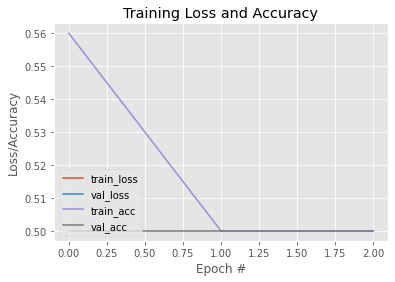

In [10]:
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, '.')

# 2- CNN Backbone Transfer Learning with contrastive_loss


In [11]:
%pip install randimage
%matplotlib inline
from randimage import get_random_image, show_array
import random
import pandas as pd
from sklearn.datasets import load_digits
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
# from keras import backend as K

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers, layers, Model, Input
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model,load_model, model_from_json
import tensorflow as tf

#enable eager execution in tensorflow
tf.config.run_functions_eagerly(True)


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: /Users/mernahesham/tf-test/env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Load Digits

In [12]:
digits_ = load_digits()
target_ = digits_['target']
target_ = train_labels = to_categorical(target_, num_classes=10)
digits = digits_['data'].reshape(-1,8,8)

digits_resize = np.zeros((len(digits),32,32))

for x,y in enumerate(digits):
    digits_resize[x] = (cv2.resize(y, dsize=(32,32), interpolation=cv2.INTER_CUBIC)+1)/2

## Build CNN model

In [13]:
def build_CNN_model_2(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(10, activation="softmax")(x)

    return Model(inputs, x)


input_shape=(32,32,1)
base_model = build_CNN_model_2(input_shape)
rms = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#RMSprop()
rms = RMSprop()
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

base_model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=["accuracy"])
base_model.summary()

batch_size=32

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)         2951

## Train CNN model on Digits

In [14]:
base_model.fit(digits_resize.reshape(-1,32,32,1), target_, validation_split=.20,batch_size= batch_size, verbose=1, epochs=10, callbacks=callback_early_stop_reduceLROnPlateau)


Epoch 1/10


/Users/mernahesham/tf-test/env/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 [==============================] - 2s 42ms/step - loss: 1.4929 - accuracy: 0.4830 - val_loss: 0.6887 - val_accuracy: 0.8111
Epoch 2/10
45/45 [==============================] - 2s 35ms/step - loss: 0.3163 - accuracy: 0.9054 - val_loss: 0.3248 - val_accuracy: 0.9139
Epoch 3/10
45/45 [==============================] - 2s 37ms/step - loss: 0.1312 - accuracy: 0.9527 - val_loss: 0.2853 - val_accuracy: 0.9139
Epoch 4/10
45/45 [==============================] - 2s 33ms/step - loss: 0.1200 - accuracy: 0.9659 - val_loss: 0.7171 - val_accuracy: 0.8417
Epoch 5/10
45/45 [==============================] - 2s 35ms/step - loss: 0.0906 - accuracy: 0.9722 - val_loss: 0.2551 - val_accuracy: 0.9361
Epoch 6/10
45/45 [==============================] - 2s 34ms/step - loss: 0.0351 - accuracy: 0.9923 - val_loss: 0.6581 - val_accuracy: 0.8806
Epoch 7/10
45/45 [==============================] - 2s 34ms/step - loss: 0.0995 - accuracy: 0.9819 - val_loss: 0.2470 - val_accuracy: 0.9333
Epoch 8/10
45/45 [======

## Helper Functions

In [15]:
def euclidean_distance(vects):
    #euclidean distance, output for Siamese network
    x, y = vects
    return tf.math.sqrt(tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

def accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, y_true.dtype)), tf.float32))

def contrastive_loss(y_true, y_pred):
    assert isinstance(y_true, tf.Tensor), "y_true must be a TensorFlow tensor"
    assert isinstance(y_pred, tf.Tensor), "y_pred must be a TensorFlow tensor"

    margin = 1
    return tf.reduce_mean(y_true * tf.math.square(y_pred) + (1 - y_true) * tf.math.square(tf.math.maximum(margin - y_pred, 0)))



## Make Pairs

In [16]:
one = []
zero = []

img_size = (32,32)

for x in range(200):

    img = get_random_image(img_size)

    #picking random a,b,c,d coordinates for plotting rectangle
    a,b = random.randrange(0,img_size[0]/4),random.randrange(0,img_size[0]/4)
    c,d = random.randrange(img_size[0]/2,img_size[0]),random.randrange(img_size[0]/2,img_size[0])

    value = random.sample([True,False],1)[0]
    if value==False:
        #plotting rectangle
        img[a:c,b:d,0] = 25
        img[a:c,b:d,1] = 25
        img[a:c,b:d,2] = 25
        #convert RGB image to black & white
        img = np.asarray(Image.fromarray((img*255).astype(np.uint8)).convert('L'))/255
        one.append(img)
    else:
        img = np.asarray(Image.fromarray((img*255).astype(np.uint8)).convert('L'))/255
        zero.append(img)

In [17]:
total_sample_size = 50
test_sample_size = 200
dim1,dim2 = 32,32
count = 0

x_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
y = np.zeros([total_sample_size,1])

x_pair_test = np.zeros([test_sample_size, 2, 1, dim1, dim2])
y_test = np.zeros([test_sample_size,1])

for x in range(total_sample_size):
    value = random.sample([True,False],1)[0]
    if value:
            pair = random.choices(one, k=2)
            x_pair[x,0,0,:,:] = pair[0]
            x_pair[x,1,0,:,:] = pair[1]
            #setting label=1 for similar images
            y[x] = 1

    else:
            x_pair[x,0,0,:,:] = random.choices(one, k=1)[0]
            x_pair[x,1,0,:,:] = random.choices(zero, k=1)[0]
            #setting label=0 for dissimilar images
            y[x] = 0


for x in range(test_sample_size):
    value = random.sample([True,False],1)[0]
    if value:
            pair = random.choices(one, k=2)
            x_pair_test[x,0,0,:,:] = pair[0]
            x_pair_test[x,1,0,:,:] = pair[1]
            y_test[x] = 1

    else:
            x_pair_test[x,0,0,:,:] = random.choices(one, k=1)[0]
            x_pair_test[x,1,0,:,:] = random.choices(zero, k=1)[0]
            y_test[x] = 0

## Build Siamese Network

In [18]:
#remove the final output layer from the CNN we added for MNIST Classification
model_temp= Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

input_dim = x_pair.shape[3:]+ tuple([1])

img_a = layers.Input(shape=input_dim)
img_b = layers.Input(shape=input_dim)

feat_vecs_a = model_temp(img_a)
feat_vecs_b = model_temp(img_b)

#Siamese output using utility functions declared above
distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [19]:
rms = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#RMSprop()
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

siamese_model_cnn_pretrained = Model(inputs=[img_a, img_b], outputs=distance)
siamese_model_cnn_pretrained.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
siamese_model_cnn_pretrained.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 model_3 (Functional)           (None, 128)          1058688     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['model_3[0][0]',          

In [20]:
img1 = x_pair[:, 0].reshape(-1,32,32,1)
img2 = x_pair[:, 1].reshape(-1,32,32,1)

img3 = x_pair_test[:, 0].reshape(-1,32,32,1)
img4 = x_pair_test[:, 1].reshape(-1,32,32,1)

batch_size = 8


In [21]:
img4.shape

(200, 32, 32, 1)

In [22]:
siamese_model_cnn_pretrained.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 model_3 (Functional)           (None, 128)          1058688     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['model_3[0][0]',          

## Train Siamese Network

In [23]:
batch_size = 8
history = siamese_model_cnn_pretrained.fit([img1, img2], y, validation_data=([img3,img4],y_test),
      batch_size= batch_size, verbose=1, epochs=10, callbacks=callback_early_stop_reduceLROnPlateau)



Epoch 1/10
7/7 [==============================] - 1s 112ms/step - loss: 0.2602 - accuracy: 0.5357 - val_loss: 0.2933 - val_accuracy: 0.5300
Epoch 2/10
7/7 [==============================] - 0s 69ms/step - loss: 0.1930 - accuracy: 0.7679 - val_loss: 0.2651 - val_accuracy: 0.5750
Epoch 3/10
7/7 [==============================] - 0s 69ms/step - loss: 0.1455 - accuracy: 0.7857 - val_loss: 0.2591 - val_accuracy: 0.6000
Epoch 4/10
7/7 [==============================] - 1s 81ms/step - loss: 0.1175 - accuracy: 0.8929 - val_loss: 0.2526 - val_accuracy: 0.6200
Epoch 5/10
7/7 [==============================] - 0s 67ms/step - loss: 0.1022 - accuracy: 0.9107 - val_loss: 0.2454 - val_accuracy: 0.6250
Epoch 6/10
7/7 [==============================] - 1s 97ms/step - loss: 0.0863 - accuracy: 0.9643 - val_loss: 0.2292 - val_accuracy: 0.6600
Epoch 7/10
7/7 [==============================] - 0s 67ms/step - loss: 0.0745 - accuracy: 0.9821 - val_loss: 0.2164 - val_accuracy: 0.6850
Epoch 8/10
7/7 [==========

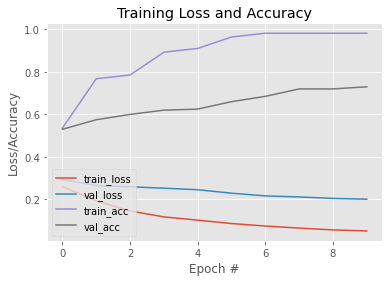

In [24]:
plot_training(history, '.')

# 3- ResNet Pre-trained with Triple Loss

## Load the dataset
We are going to load the Totally Looks Like dataset and unzip it inside the ~/.keras directory in the local environment.

The dataset consists of two separate files:

left.zip contains the images that we will use as the anchor.
right.zip contains the images that we will use as the positive sample (an image that looks like the anchor).

In [41]:
from keras.applications import resnet
from keras import metrics


In [29]:
anchor_images_path = "./lab6/left"
positive_images_path = "./lab6/right"

target_shape = (200, 200)

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

## Preparing the data

In [30]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(anchor_images_path +'/'+ f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path +'/'+ f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

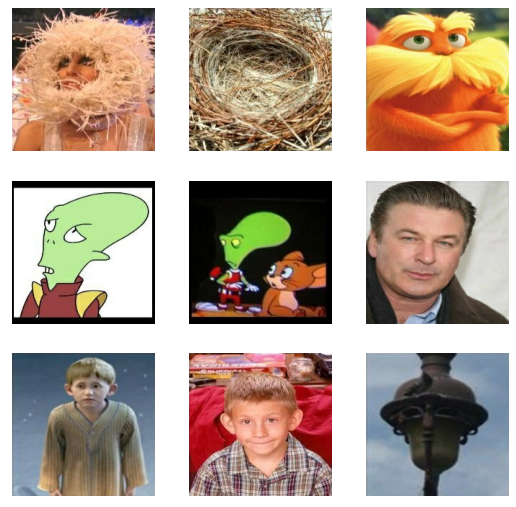

In [31]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Preparing ResNet50 Backbone

In [37]:
base_resnet = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_resnet.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_resnet.input, output, name="Embedding")

trainable = False
for layer in base_resnet.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


## Computing Differences

In [38]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

## Siamese Network

In [39]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    

In [42]:
siamese_model_resnet_triple = SiameseModel(siamese_network)
siamese_model_resnet_triple.compile(optimizer=optimizers.Adam(0.0001), metrics=['accuracy'], 
                  weighted_metrics=['accuracy'])
siamese_model_resnet_triple.fit(train_dataset, epochs=10,verbose=1, validation_data=val_dataset)

Epoch 1/10
151/151 [==============================] - 449s 3s/step - loss: 0.4938 - val_loss: 0.3898
Epoch 2/10
151/151 [==============================] - 312s 2s/step - loss: 0.3860 - val_loss: 0.3841
Epoch 3/10
151/151 [==============================] - 288s 2s/step - loss: 0.3646 - val_loss: 0.3467
Epoch 4/10
151/151 [==============================] - 266s 2s/step - loss: 0.3600 - val_loss: 0.3639
Epoch 5/10
151/151 [==============================] - 246s 2s/step - loss: 0.3424 - val_loss: 0.3322
Epoch 6/10
151/151 [==============================] - 252s 2s/step - loss: 0.3405 - val_loss: 0.3295
Epoch 7/10
151/151 [==============================] - 257s 2s/step - loss: 0.3253 - val_loss: 0.3415
Epoch 8/10
151/151 [==============================] - 658s 4s/step - loss: 0.3212 - val_loss: 0.3051
Epoch 9/10
151/151 [==============================] - 232s 2s/step - loss: 0.3070 - val_loss: 0.3122
Epoch 10/10
151/151 [==============================] - 241s 2s/step - loss: 0.3036 - val_lo

## Validating Output

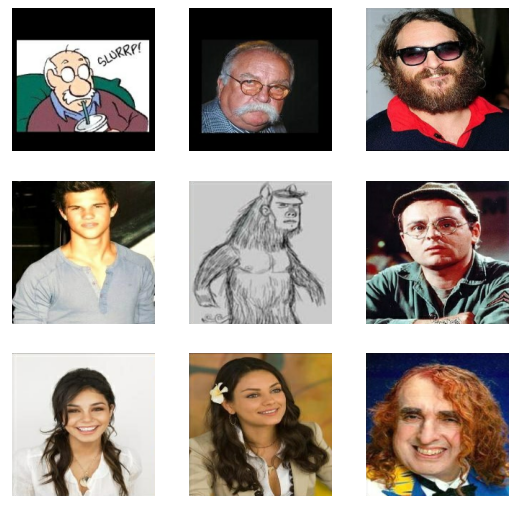

In [43]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)


In [44]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99398565
Negative similarity 0.9917279


## Lab Practice:

Using MNIST datset from Tensorflow keras in first part, retrain a siamese model with the pretrained CNN on digits dataset from sklearn from second part.

Which dataset will give higher accuracy on the siamese with pretrained cnn? 
What can we do to make this model has higher accuracy? hint: compare both datasets.


## Extra:

Using the digits dataset from second part, train first part CNN as backbone instead of the current CNN and then retrain siamese model with pretrained. 

which CNN backbone resulted in better performance? hint: compare both CNN blocks.